# Experiment: Inducing Points
In this experiment, we invesigate the effects of using a different number of inducing points and how it effects the sparse GP model.

## Procedure
Combine Squared-Exponential (SE) kernel, Linear kernel, Matern kernel, Sinusoidal kernel, and Spectral Mixture kernel (10 mixture components).

In [ ]:
import numpy as onp
import matplotlib.pyplot as plt
from sparse_gp import *
from plots import *
from data import *

prng_key = random.key(0)

['time_step', 'Manchester_City_F.C.', 'Chelsea_F.C.', 'Liverpool_F.C.', 'Arsenal_F.C.']


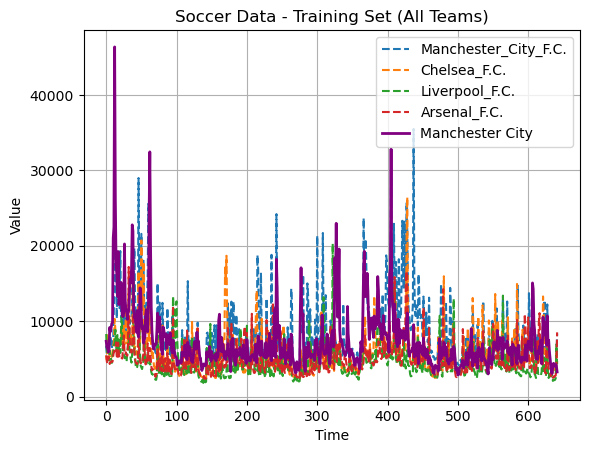

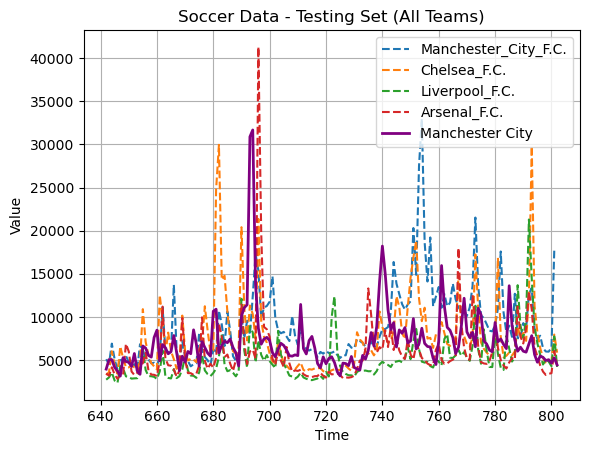

In [2]:
# Load datasets
all_data = load_all()
tech = load_tech()
politics = load_politics()
soccer = load_soccer()

# Example: Split Soccer data into training and testing sets
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = split_train_test_matrix(soccer, train_ratio=0.8, target_column=0)

# Generate integer day labels
time_train = np.arange(X_train_soccer.shape[0])  # Days for training set
time_test = np.arange(X_train_soccer.shape[0], X_train_soccer.shape[0] + X_test_soccer.shape[0])  # Days for testing set

# Soccer group feature names (e.g., team names)
soccer_feature_names = ["time_step"] + [
    row[0].split("_en.wikipedia.org")[0] for row in soccer if row[0] != soccer[0, 0]
]

print(soccer_feature_names)

# Plot all soccer teams in the training set
plot_time_series(
    X=X_train_soccer, 
    Y=y_train_soccer, 
    time=time_train, 
    feature_names=soccer_feature_names, 
    target_name="Manchester City",  # Example target
    title="Soccer Data - Training Set (All Teams)"
)

# Plot all soccer teams in the testing set
plot_time_series(
    X=X_test_soccer, 
    Y=y_test_soccer, 
    time=time_test, 
    feature_names=soccer_feature_names, 
    target_name="Manchester City",  # Example target
    title="Soccer Data - Testing Set (All Teams)"
)


# 25 Inducing Points
Test on soccer data with 25 inducing points.

## Parameter Initialization

In [3]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=25)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)

## Define the Optimization Loop for ELBO

In [4]:
# Set the gradient ascent step size and number of steps
step_size = 1e-8
num_steps = 1000

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -614924619.2022423
Step 10, ELBO: -40855900.693998925
Step 20, ELBO: -22566667.928579006
Step 30, ELBO: -15659272.596294925
Step 40, ELBO: -12007818.250870917
Step 50, ELBO: -9743791.532657655
Step 60, ELBO: -8200787.943577941
Step 70, ELBO: -7080887.365493486
Step 80, ELBO: -6230663.1943758
Step 90, ELBO: -5562980.1766597815
Step 100, ELBO: -5024641.777833401
Step 110, ELBO: -4581317.5425888095
Step 120, ELBO: -4209856.112393142
Step 130, ELBO: -3894068.8652511225
Step 140, ELBO: -3622300.7142959796
Step 150, ELBO: -3385936.070226363
Step 160, ELBO: -3178475.818825381
Step 170, ELBO: -2994913.196685406
Step 180, ELBO: -2831349.416402838
Step 190, ELBO: -2684678.9089871054
Step 200, ELBO: -2552413.4556296333
Step 210, ELBO: -2432528.6023759414
Step 220, ELBO: -2323365.6366063827
Step 230, ELBO: -2223549.5622623824
Step 240, ELBO: -2131925.0906790183
Step 250, ELBO: -2047528.424736816
Step 260, ELBO: -1969533.2387952742
Step 270, ELBO: -1897241.3066073596
Step 280, ELBO: -

In [5]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 7325.2334


## Predict and Plot the Results

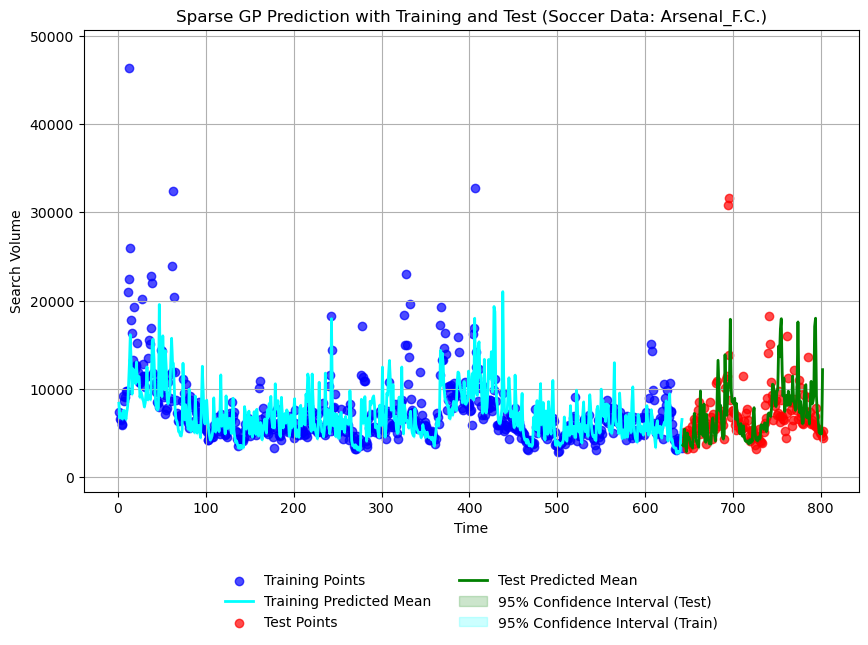

In [6]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

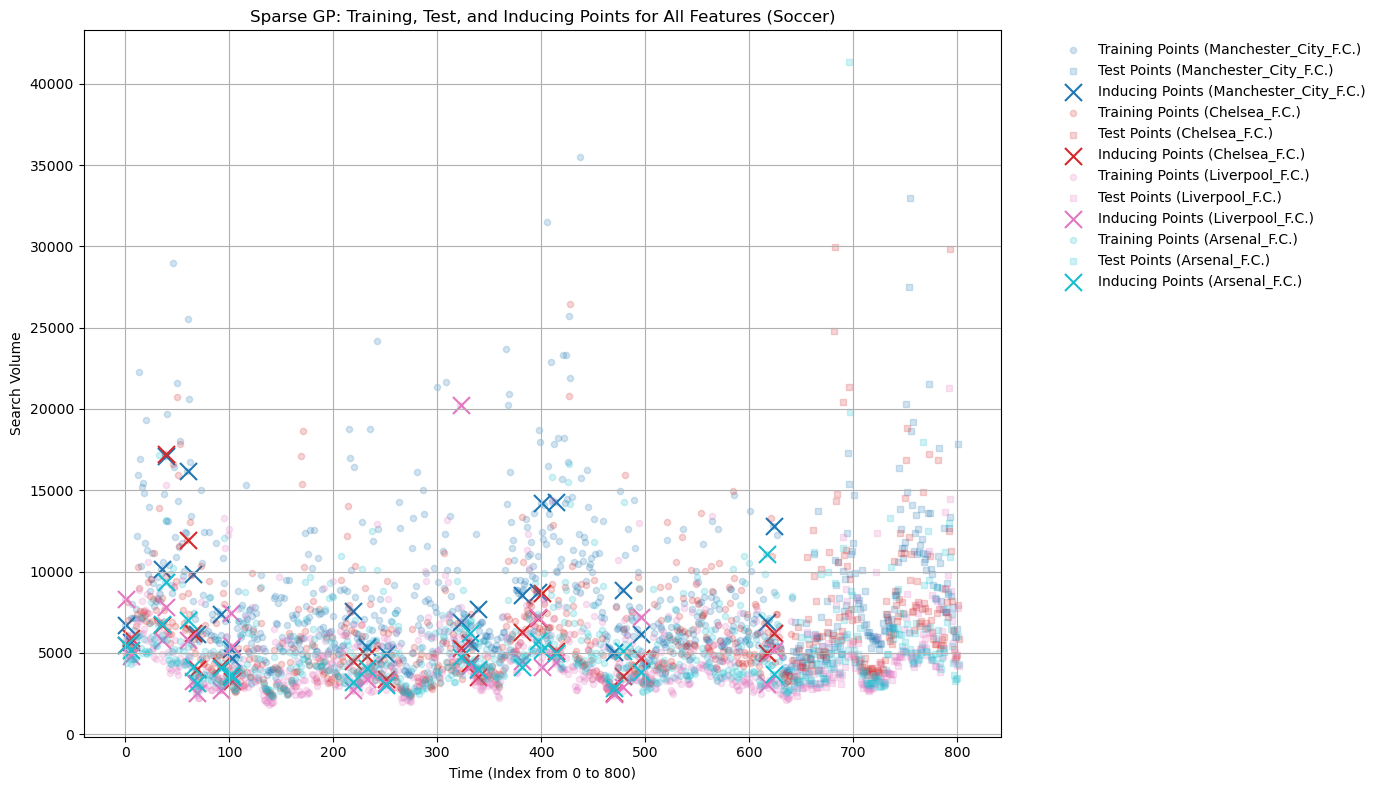

In [7]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [8]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 0.9547
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.8553
Kernel 4 (Sinusoidal): 1.2587
Kernel 5 (Spectral Mixture): 0.8360

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 16.17%
Kernel 2 (Linear): 16.94%
Kernel 3 (Matérn): 31.42%
Kernel 4 (Sinusoidal): 21.32%
Kernel 5 (Spectral Mixture): 14.16%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1465.0466
Kernel 1 - Signal Variance: 2.5952
Kernel 1 - Length Scale: 22026.2559
Kernel 2 - Noise Variance: 1465.0466
Kernel 2 - Signal Variance: 2.7183
Kernel 3 - Noise Variance: 1465.0466
Kernel 3 - Signal Variance: 5.0431
Kernel 3 - Length Scale: 17337.0645
Kernel 4 - Noise Variance: 1465.0466
Kernel 4 - Signal Variance: 3.4214
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183
Kernel 5 - Noise Variance: 1465.0466

Spectral Mixture Kernel - Mixture 1:
Weight: 1.0856
Means: [0.22082484 0.8361463  0.0082743  1.3717978  3.6921637 ]
Variances: [1.78990135e+01 3.26999130e

## NLPD

In [9]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 399.9212
Test NLPD: 580.5408


## MSE

In [10]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 16892358.7382


## ELBO Maximization

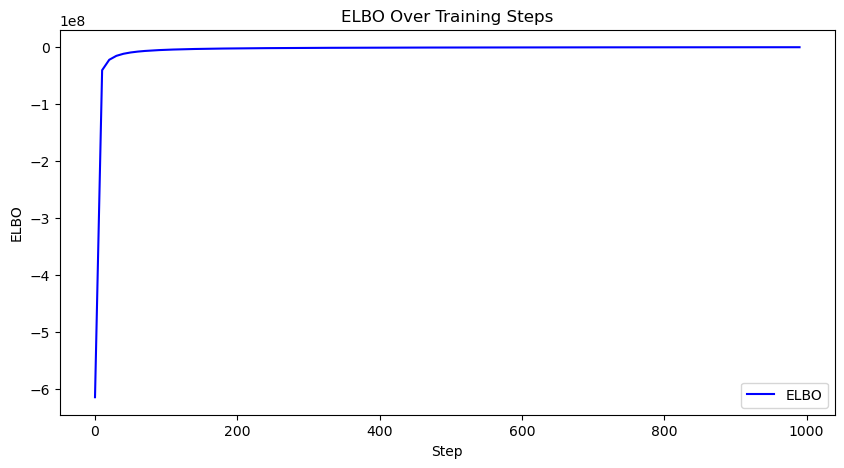

In [11]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Length Scale (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Mean 5, Dim 1
 - SM Variance 5, Dim 1
 - SM Mean 5, Dim 2


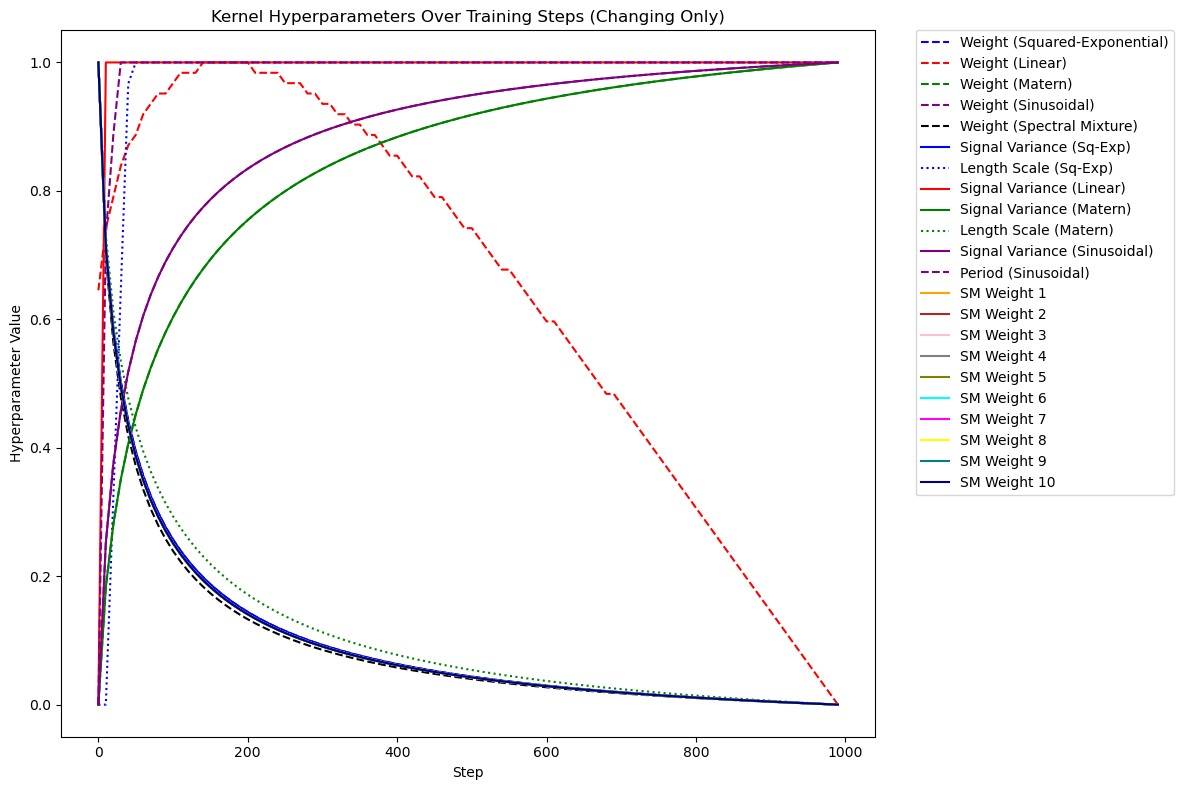

In [12]:
plot_kernel_hyperparameters(history, num_spectral_mixtures=10, dims=5)

# 50 Inducing Points
Test on soccer data with 50 inducing points.

## Parameter Initialization

In [13]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=50)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)

## Define the Optimization Loop for ELBO

In [14]:
# Set the gradient ascent step size and number of steps
step_size = 1e-8
num_steps = 1000

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -604866655.6108452
Step 10, ELBO: -41181829.13747194
Step 20, ELBO: -22714125.45445778
Step 30, ELBO: -15749406.456319118
Step 40, ELBO: -12070547.934475807
Step 50, ELBO: -9790694.631720092
Step 60, ELBO: -8237459.22144479
Step 70, ELBO: -7110451.437409212
Step 80, ELBO: -6255034.803624684
Step 90, ELBO: -5583412.0812414875
Step 100, ELBO: -5041994.074604406
Step 110, ELBO: -4596203.0657923175
Step 120, ELBO: -4222735.727747939
Step 130, ELBO: -3905292.7250224235
Step 140, ELBO: -3632136.8395095076
Step 150, ELBO: -3394600.725781959
Step 160, ELBO: -3186134.746518898
Step 170, ELBO: -3001712.5757329687
Step 180, ELBO: -2837398.70425693
Step 190, ELBO: -2690075.6720704925
Step 200, ELBO: -2557239.779573237
Step 210, ELBO: -2436852.587190025
Step 220, ELBO: -2327242.996779782
Step 230, ELBO: -2227026.9499373804
Step 240, ELBO: -2135047.986299524
Step 250, ELBO: -2050333.9011902022
Step 260, ELBO: -1972054.5098373971
Step 270, ELBO: -1899505.036297157
Step 280, ELBO: -18320

In [15]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 7341.157


## Predict and Plot the Results

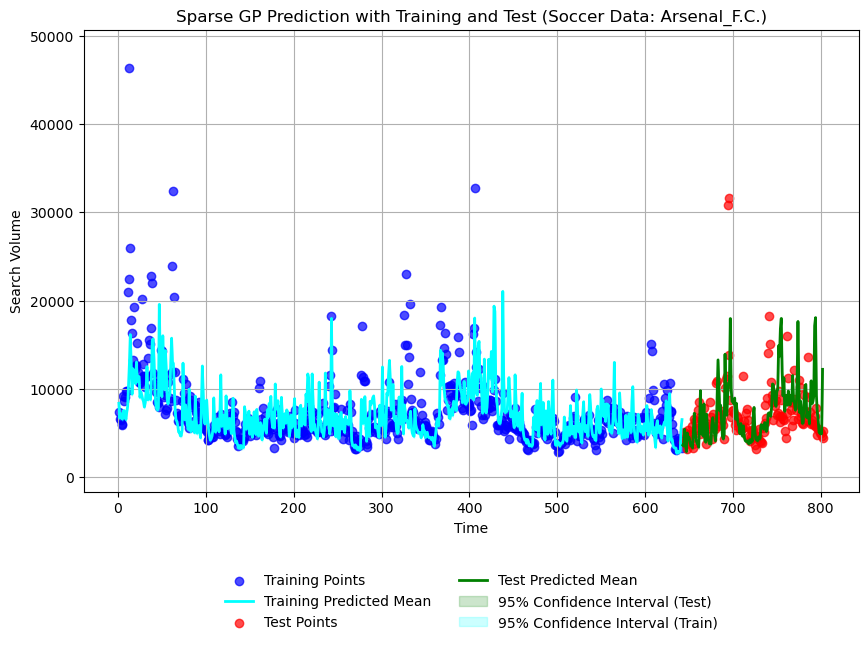

In [16]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

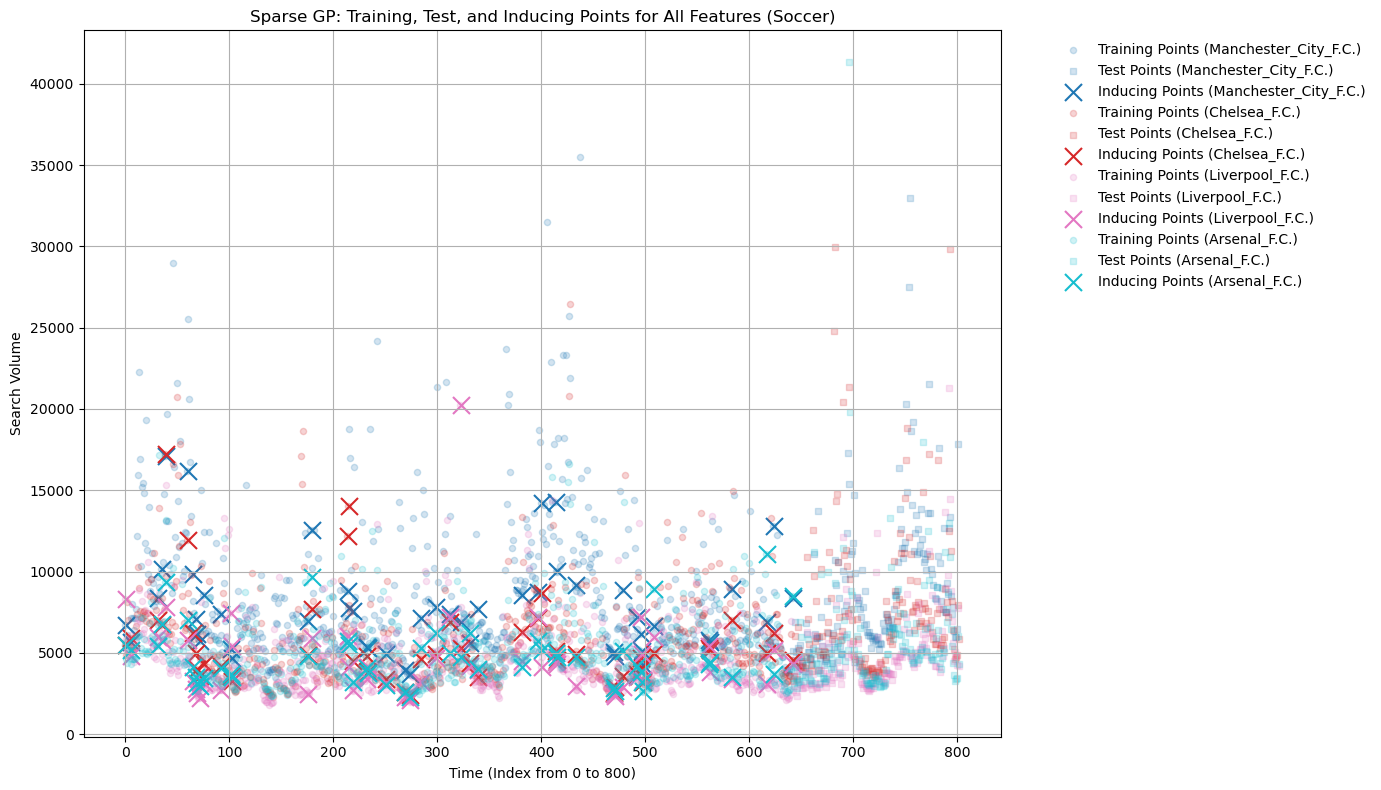

In [17]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [18]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 0.9906
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.6436
Kernel 4 (Sinusoidal): 1.2423
Kernel 5 (Spectral Mixture): 0.9629

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 16.96%
Kernel 2 (Linear): 17.12%
Kernel 3 (Matérn): 28.15%
Kernel 4 (Sinusoidal): 21.27%
Kernel 5 (Spectral Mixture): 16.49%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1468.2314
Kernel 1 - Signal Variance: 2.6928
Kernel 1 - Length Scale: 22023.2305
Kernel 2 - Noise Variance: 1468.2314
Kernel 2 - Signal Variance: 2.7183
Kernel 3 - Noise Variance: 1468.2314
Kernel 3 - Signal Variance: 4.4677
Kernel 3 - Length Scale: 18941.2480
Kernel 4 - Noise Variance: 1468.2314
Kernel 4 - Signal Variance: 3.3769
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7184
Kernel 5 - Noise Variance: 1468.2314

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1010
Means: [0.22082484 0.8361463  0.0082743  1.3717978  3.6921637 ]
Variances: [1.78990135e+01 3.26999130e

## NLPD

In [19]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 400.0451
Test NLPD: 582.2233


## MSE

In [20]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 16961921.3506


## ELBO Maximization

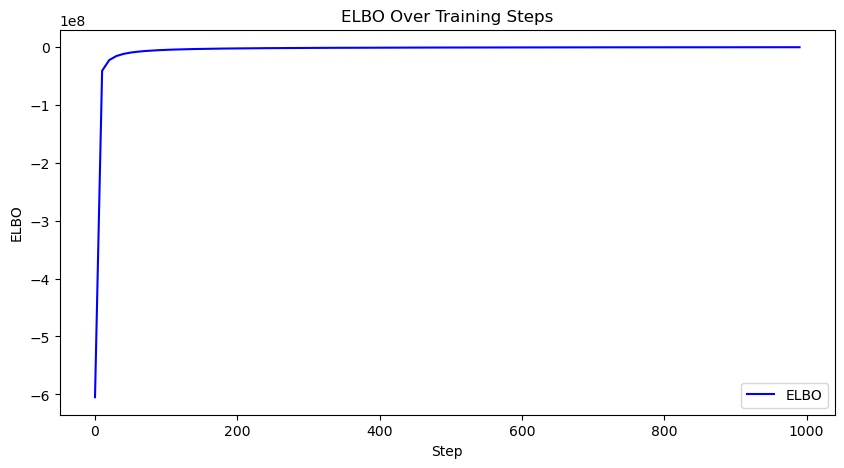

In [21]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Length Scale (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Mean 5, Dim 1
 - SM Variance 5, Dim 1
 - SM Mean 5, Dim 2


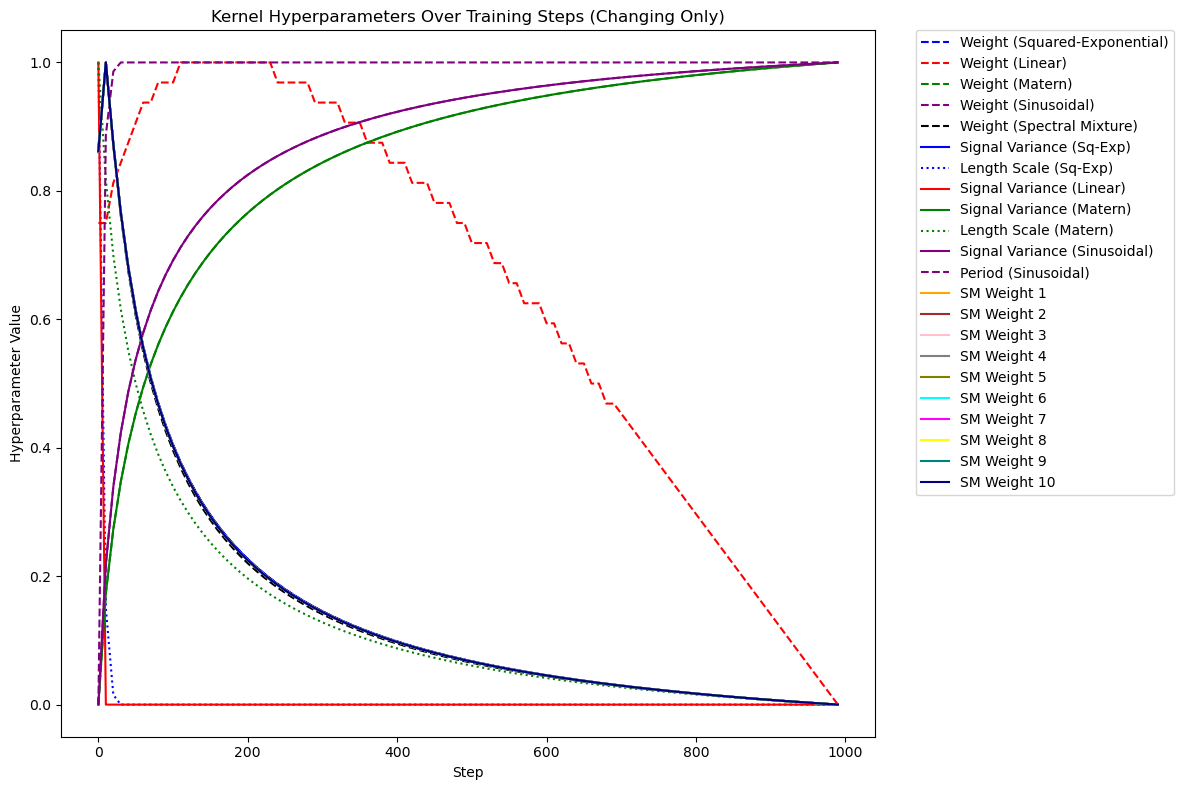

In [22]:
plot_kernel_hyperparameters(history, num_spectral_mixtures=10, dims=5)

# 100 Inducing Points
Test on soccer data with 100 inducing points.

## Parameter Initialization

In [23]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=100)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)

## Define the Optimization Loop for ELBO

In [24]:
# Set the gradient ascent step size and number of steps
step_size = 1e-8
num_steps = 1000

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -575815048.8141729
Step 10, ELBO: -42284961.183380045
Step 20, ELBO: -23202740.41981932
Step 30, ELBO: -16038624.934793383
Step 40, ELBO: -12266561.247008532
Step 50, ELBO: -9934500.391890643
Step 60, ELBO: -8348635.088168015
Step 70, ELBO: -7199650.703745517
Step 80, ELBO: -6328609.29424563
Step 90, ELBO: -5645415.659292329
Step 100, ELBO: -5095150.764433135
Step 110, ELBO: -4642421.858204988
Step 120, ELBO: -4263390.426173069
Step 130, ELBO: -3941407.493031676
Step 140, ELBO: -3664487.148278617
Step 150, ELBO: -3423790.8035017387
Step 160, ELBO: -3212642.2085121837
Step 170, ELBO: -3025920.6793727786
Step 180, ELBO: -2859617.213667824
Step 190, ELBO: -2710561.9157648673
Step 200, ELBO: -2576201.139043597
Step 210, ELBO: -2454465.5169173134
Step 220, ELBO: -2343660.107521724
Step 230, ELBO: -2242377.5073812776
Step 240, ELBO: -2149441.190797515
Step 250, ELBO: -2063859.760022672
Step 260, ELBO: -1984796.904368573
Step 270, ELBO: -1911535.598320798
Step 280, ELBO: -184345

In [25]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 7314.3154


## Predict and Plot the Results

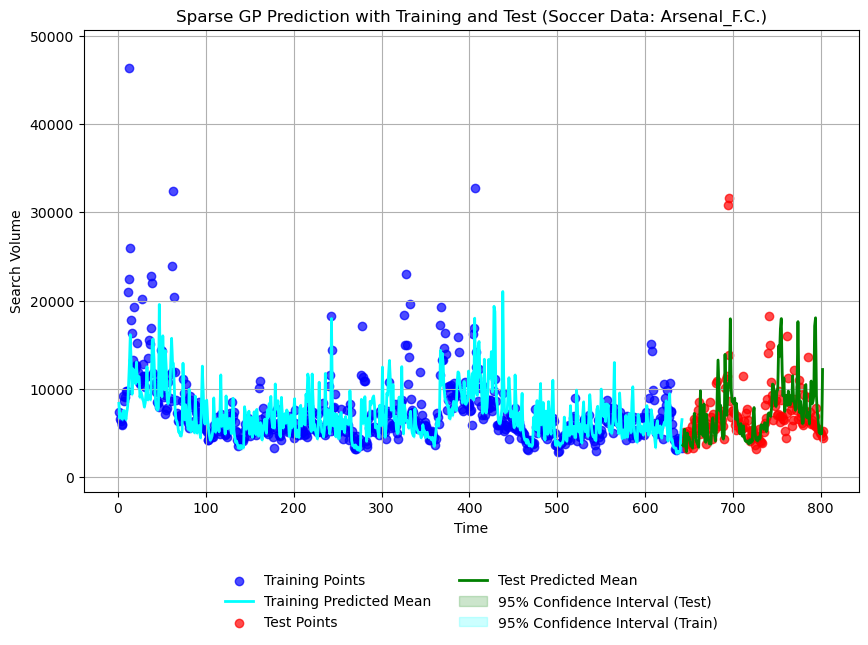

In [26]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

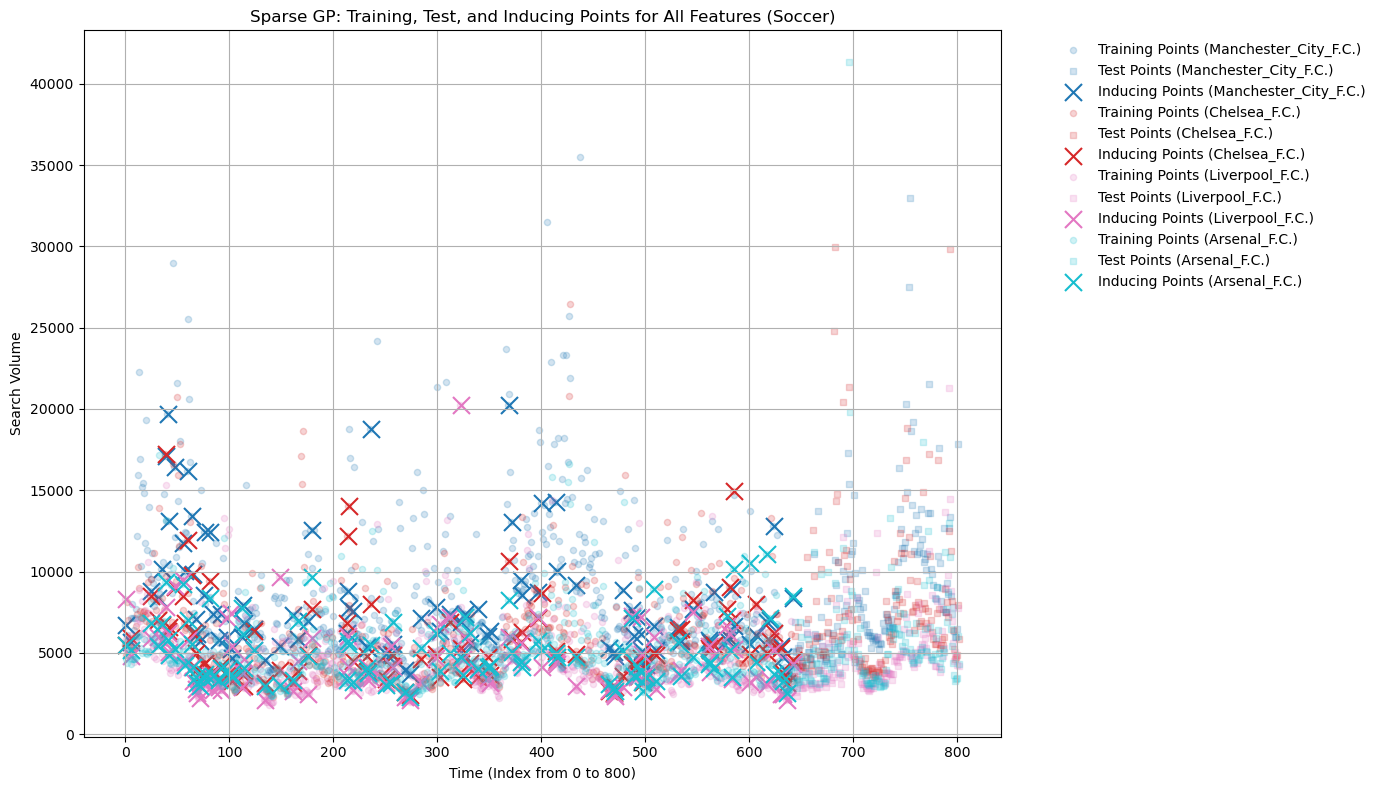

In [27]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [28]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.0516
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.6243
Kernel 4 (Sinusoidal): 1.1947
Kernel 5 (Spectral Mixture): 1.2392

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 17.21%
Kernel 2 (Linear): 16.37%
Kernel 3 (Matérn): 26.59%
Kernel 4 (Sinusoidal): 19.55%
Kernel 5 (Spectral Mixture): 20.28%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1462.8630
Kernel 1 - Signal Variance: 2.8584
Kernel 1 - Length Scale: 22034.1973
Kernel 2 - Noise Variance: 1462.8630
Kernel 2 - Signal Variance: 2.7183
Kernel 3 - Noise Variance: 1462.8630
Kernel 3 - Signal Variance: 4.4153
Kernel 3 - Length Scale: 17864.9336
Kernel 4 - Noise Variance: 1462.8630
Kernel 4 - Signal Variance: 3.2474
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7184
Kernel 5 - Noise Variance: 1462.8630

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1291
Means: [0.22082484 0.8361463  0.0082743  1.3717978  3.6921637 ]
Variances: [1.78990135e+01 3.26999130e

## NLPD

In [29]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 401.0016
Test NLPD: 583.6561


## MSE

In [30]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 16940356.9013


## ELBO Maximization

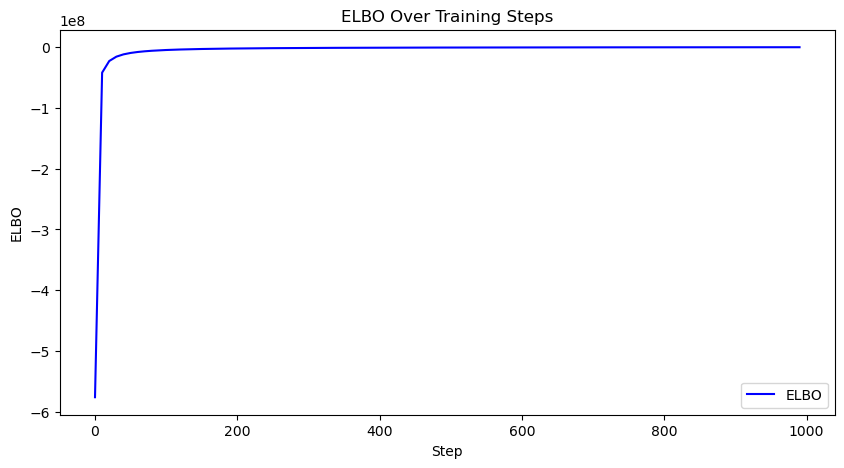

In [31]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Signal Variance (Linear)
 - Length Scale (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Mean 5, Dim 1
 - SM Variance 5

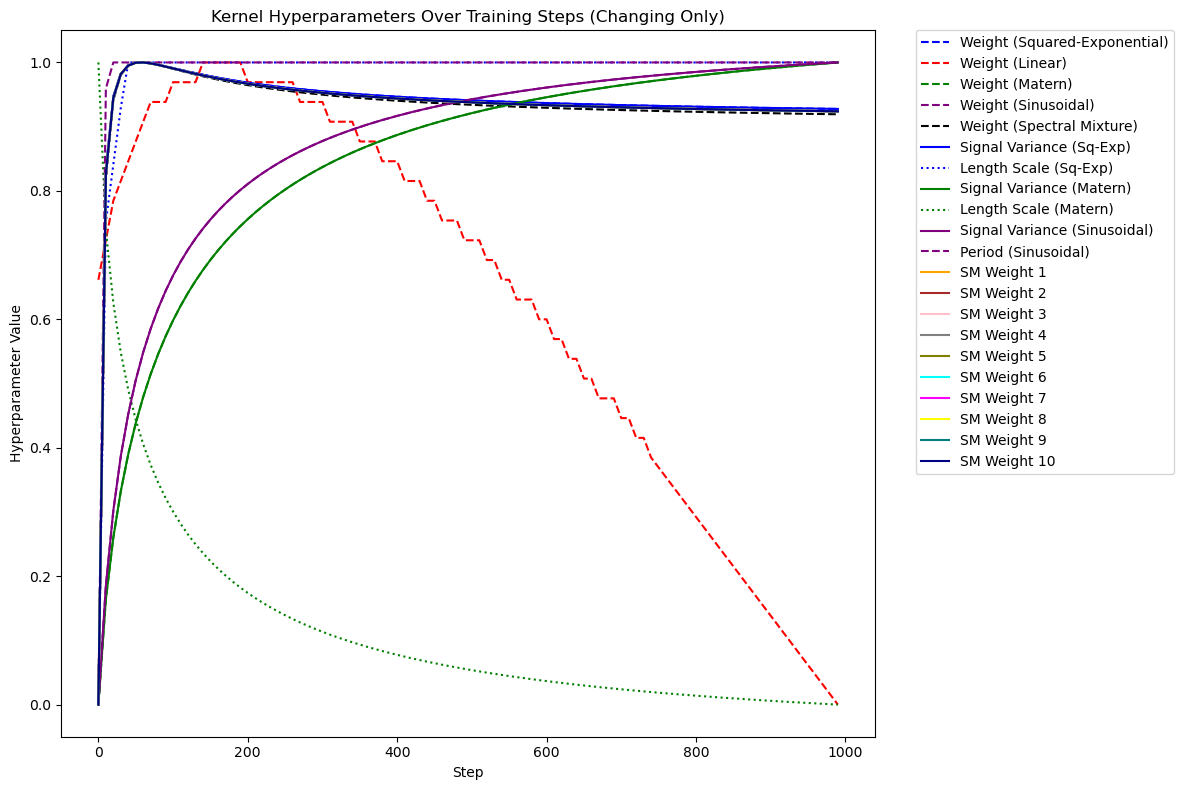

In [32]:
plot_kernel_hyperparameters(history, num_spectral_mixtures=10, dims=5)

# 200 Inducing Points
Test on soccer data with 200 inducing points.

## Parameter Initialization

In [33]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=200)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)

## Define the Optimization Loop for ELBO

In [34]:
# Set the gradient ascent step size and number of steps
step_size = 1e-8
num_steps = 1000

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -522560836.66080856
Step 10, ELBO: -44701832.931777164
Step 20, ELBO: -24407742.64692462
Step 30, ELBO: -16794802.85405514
Step 40, ELBO: -12796283.430779804
Step 50, ELBO: -10331047.088100025
Step 60, ELBO: -8659106.273433099
Step 70, ELBO: -7450759.166229756
Step 80, ELBO: -6536785.164141239
Step 90, ELBO: -5821387.983208509
Step 100, ELBO: -5246259.8440554915
Step 110, ELBO: -4773873.066150206
Step 120, ELBO: -4378996.143722532
Step 130, ELBO: -4044023.8702783585
Step 140, ELBO: -3756310.3402336612
Step 150, ELBO: -3506531.8211269984
Step 160, ELBO: -3287657.664707869
Step 170, ELBO: -3094303.9870901164
Step 180, ELBO: -2922257.8890634873
Step 190, ELBO: -2768191.9894791623
Step 200, ELBO: -2629434.1112024733
Step 210, ELBO: -2503813.9883606466
Step 220, ELBO: -2389556.2286145343
Step 230, ELBO: -2285189.9908629525
Step 240, ELBO: -2189487.336217795
Step 250, ELBO: -2101415.947052843
Step 260, ELBO: -2020099.276494955
Step 270, ELBO: -1944790.3200526128
Step 280, ELBO:

In [35]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 7249.8887


## Predict and Plot the Results

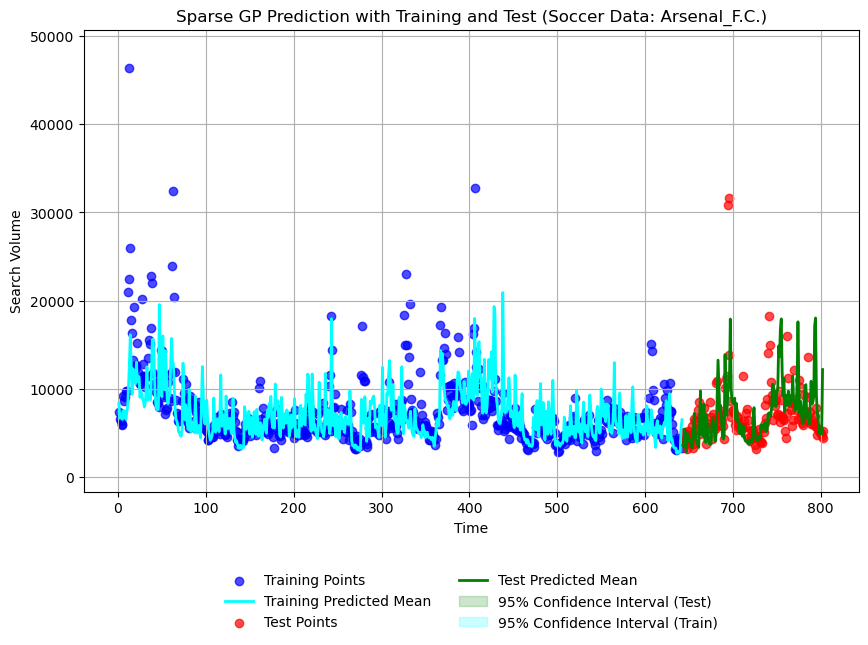

In [36]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

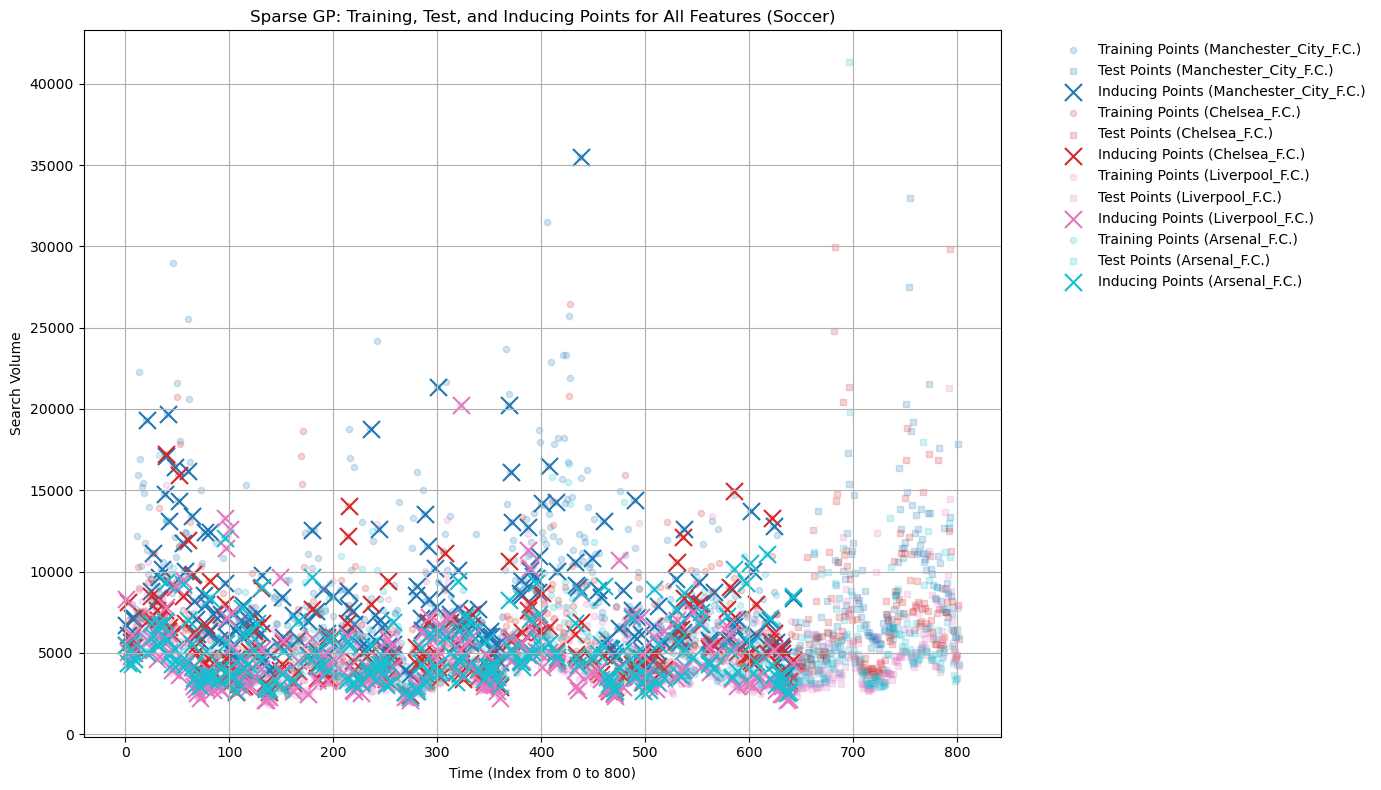

In [37]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [38]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.1747
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.6194
Kernel 4 (Sinusoidal): 1.1625
Kernel 5 (Spectral Mixture): 2.2745

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 16.24%
Kernel 2 (Linear): 13.83%
Kernel 3 (Matérn): 22.39%
Kernel 4 (Sinusoidal): 16.08%
Kernel 5 (Spectral Mixture): 31.45%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1449.9778
Kernel 1 - Signal Variance: 3.1931
Kernel 1 - Length Scale: 22034.0918
Kernel 2 - Noise Variance: 1449.9778
Kernel 2 - Signal Variance: 2.7183
Kernel 3 - Noise Variance: 1449.9778
Kernel 3 - Signal Variance: 4.4020
Kernel 3 - Length Scale: 16930.9805
Kernel 4 - Noise Variance: 1449.9778
Kernel 4 - Signal Variance: 3.1600
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183
Kernel 5 - Noise Variance: 1449.9778

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1998
Means: [0.22082484 0.8361463  0.0082743  1.3717978  3.6921637 ]
Variances: [1.78990135e+01 3.26999130e

## NLPD

In [39]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 403.2801
Test NLPD: 587.3949


## MSE

In [40]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 16915976.8913


## ELBO Maximization

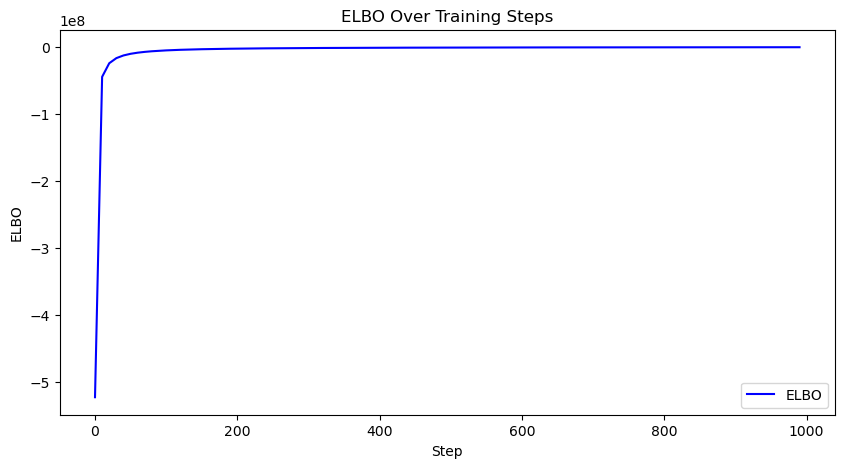

In [41]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Length Scale (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Mean 5, Dim 1
 - SM Variance 5, Dim 1
 - SM Mean 5, Dim 2


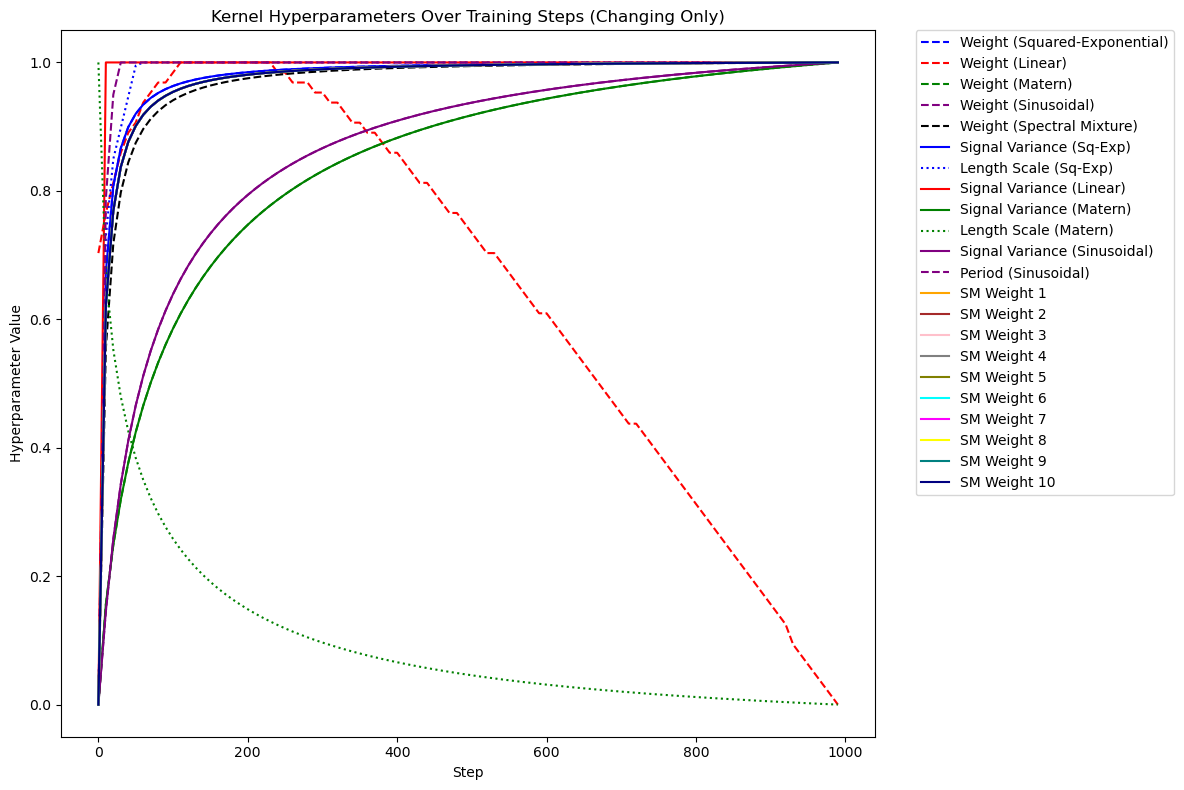

In [42]:
plot_kernel_hyperparameters(history, num_spectral_mixtures=10, dims=5)